This Jupyter notebook contains the code needed to reading the Origin-destination (OD) mobility data (as dependent variables), and the socio-demographic, land use and topological features of 577 zones in Barcelona. 

It models OD values based on a selection of these features using three approaches:
- OLS (Ordinary Linear Regression)
- Gradient Boosting with Tweedie regression using XGBoost
- A two-part Hurdle model using Gradient Boosting using XGBoost, both for the logistic regression and for the Tweedie regression with y>0

It generates 4 outputs as results:
- df_models: a Pandas dataframe containing all the models withn all the considered spatial spillover (lagged) effects.
- df_results_summary: a dataframe containing the error metrics
- df_results_shap: a dataframe for explaining the relevant variables using the SHAP method.
- data_flows: the predicted new values with each of the models.

# imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_regression
import math

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

import statsmodels.api as sm

import scipy.stats as stats

from sklearn.feature_selection import RFE
import spreg
# import cudf

import seaborn as sns

import swifter
from scipy.stats import yeojohnson
import warnings
warnings.filterwarnings("ignore")

import sys
from io import StringIO

# Temporarily redirect stdout
old_stdout = sys.stdout


In [2]:
import xgboost
xgboost.__version__

'2.0.3'

## Pickle for results saving

In [3]:
# Pickle a file and then compress it into a file with extension 
import bz2
import pickle
import _pickle as cPickle

def compressed_pickle(title, data):
    with bz2.BZ2File(title + '.pbz2', 'w') as f: 
        cPickle.dump(data, f)
    
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file + '.pbz2', 'rb')
    # data = cPickle.load(data)

    data = pd.compat.pickle_compat.load(data) # for pandas >2.0?
    
    return data

In [4]:
from matplotlib.font_manager import FontProperties

# !!! change it to your path
personal_path = '/cluster/home/jaargota/Fonts/'

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt


# Find the custom font
custom_fonts = fm.findSystemFonts(fontpaths=personal_path, fontext='ttf')

# Add the custom fonts to Matplotlib
for font in custom_fonts:
    fm.fontManager.addfont(font)

# Print the names of custom fonts to verify
for font in custom_fonts:
    print(fm.FontProperties(fname=font).get_name())

# Update the font cache (this will refresh the Matplotlib font list)
plt.rcParams.update({'font.family': 'sans-serif'})

Helvetica
Helvetica Light
Helvetica
Helvetica Compressed
Helvetica
Helvetica


In [5]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

In [6]:
# matplotlib.font_manager.findSystemFonts(fontpaths=personal_path, fontext='ttf')
# plt.rcParams['font.family']=[font_path]
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Helvetica"]

# Load data

In [9]:
all_data = decompress_pickle("../../01-data/OD_vect_on_origin_data_v21wq_selected_cols")

## Features selection and data preprocessing

In [10]:
common_vars = [
    'pop_dens_inh_per_km2',
    'area_const_x__sum__V',
    'area_const_x__sum__C',
    'area_const_x__sum__O',
    'area_const_x__sum__E',
    'area_const_x__sum__A',
    'ratio_workers',
    'dens_OSM_length_roads_non_motorways_per_km2',
    'ratio_GHSL_built_6to15m',
]
other_vars = [
    'quickest_traveltime',
    'quickest_route_centrality_mean',
    'quickest_route_centrality_max',
    'quickest_route_centrality_min',
    'graph_degree',
]

def create_prefix_list(base_vars, prefix):
    return [f'{prefix}_{var}' for var in base_vars]

o_vars = create_prefix_list(common_vars, 'o')
d_vars = create_prefix_list(common_vars, 'd')

vars_c_10007 = o_vars + d_vars + other_vars

def create_transformed_list(original_list, prefix):
    return [f'{prefix}_{var}' for var in original_list]

vars_c_10007_sqrt = create_transformed_list(vars_c_10007, 'sqrt')
vars_c_10007_log = create_transformed_list(vars_c_10007, 'log')
vars_c_10007_cbrt = create_transformed_list(vars_c_10007, 'cbrt')

In [11]:
vars_c_10007

['o_pop_dens_inh_per_km2',
 'o_area_const_x__sum__V',
 'o_area_const_x__sum__C',
 'o_area_const_x__sum__O',
 'o_area_const_x__sum__E',
 'o_area_const_x__sum__A',
 'o_ratio_workers',
 'o_dens_OSM_length_roads_non_motorways_per_km2',
 'o_ratio_GHSL_built_6to15m',
 'd_pop_dens_inh_per_km2',
 'd_area_const_x__sum__V',
 'd_area_const_x__sum__C',
 'd_area_const_x__sum__O',
 'd_area_const_x__sum__E',
 'd_area_const_x__sum__A',
 'd_ratio_workers',
 'd_dens_OSM_length_roads_non_motorways_per_km2',
 'd_ratio_GHSL_built_6to15m',
 'quickest_traveltime',
 'quickest_route_centrality_mean',
 'quickest_route_centrality_max',
 'quickest_route_centrality_min',
 'graph_degree']

### making zeroes values <1

In [12]:
all_data['daily_flow'] = all_data['daily_flow'].apply(lambda x: 0 if x < 1 else x)

In [13]:
all_data['non_zero'] = all_data['daily_flow'].apply(lambda x: 0 if x < 1 else 1)

### transform

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for c in [c for c in all_data.columns if all_data[c].dtype in numerics]:
    all_data["log_{}".format(c)] = np.log1p(all_data[c])
    all_data["cbrt_{}".format(c)] = np.cbrt(all_data[c])
    all_data["sqrt_{}".format(c)] = np.sqrt(all_data[c])

In [15]:
all_data[["daily_flow", 
          # "ine_flows_0_b", "ine_flows_1_b", "ine_flows_2_b", "ine_flows_3_b"
         ] + vars_c_10007].median()

daily_flow                                            0.000000
o_pop_dens_inh_per_km2                            14270.393472
o_area_const_x__sum__V                           364106.000000
o_area_const_x__sum__C                            36094.000000
o_area_const_x__sum__O                             7723.000000
o_area_const_x__sum__E                            12146.000000
o_area_const_x__sum__A                            49264.000000
o_ratio_workers                                       0.256259
o_dens_OSM_length_roads_non_motorways_per_km2      3328.945755
o_ratio_GHSL_built_6to15m                             0.045275
d_pop_dens_inh_per_km2                            14270.393472
d_area_const_x__sum__V                           364106.000000
d_area_const_x__sum__C                            36094.000000
d_area_const_x__sum__O                             7723.000000
d_area_const_x__sum__E                            12146.000000
d_area_const_x__sum__A                            49264

# General helpers

In [30]:
# Plot histograms with KDE
def plot_hist(data, y_pred, y_pred_duan=None):
    # Generate example data
    data1 = data["log_daily_flow"]
    # data2 = np.log1p(y_pred_duan)
    data3 = np.log1p(y_pred)
    
    sns.histplot(data1, kde=True, color='blue', label='Data 1', stat='density', bins=20)
    sns.histplot(data3, kde=True, color='green', label='Data 3', stat='density', bins=20)

    plt.title('Histograms with KDE')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    return None

## OD Matrix comparison plotting
These functions enable the plotting of OD matrices between the 577 zones of the RMB to evaluate and compare results graphically

### agg. / diff. functions

In [17]:
def diff_OD_mat(new_matrix, old_matrix):
    # compute diffs
    norm_change_matrix = np.divide((new_matrix - old_matrix), old_matrix, out=np.zeros_like(old_matrix), where=old_matrix!=0)
    return norm_change_matrix

def diff_abs_OD_mat(new_matrix, old_matrix):
    # compute diffs
    change_matrix = np.subtract(new_matrix, old_matrix)
    return change_matrix

def diff_OD_mat_perc(new_matrix, old_matrix):
    # compute diffs
    norm_change_matrix = np.divide((new_matrix - old_matrix), old_matrix, out=np.zeros_like(old_matrix), where=old_matrix!=0, casting="unsafe")*100
    return norm_change_matrix

In [18]:
def diff_geh_OD_mat(model_matrix, real_matrix):
    # compute diffs
    GEH_change_matrix = np.sqrt(np.divide(2*np.square(np.subtract(model_matrix, real_matrix)), np.add(model_matrix, real_matrix), 
                                          out=np.zeros_like(np.add(model_matrix, real_matrix)), where=np.add(model_matrix, real_matrix)!=0))
    return GEH_change_matrix

In [19]:
def diff_sqv_OD_mat(model_matrix, real_matrix):
    real_matrix = real_matrix.replace(0, 0.1)
    # compute diffs
    f = 10000
    SQV_change_matrix = 1/(1+np.sqrt(((model_matrix-real_matrix)**2)/(f*real_matrix)))
    return SQV_change_matrix

## sort data by counties
sort and group the zones per counties consistently

In [20]:
shp_files_counties = {
"BARCELONES": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_BARCELONES/EMO96_BARCELONES.shp",
"ALT_PENEDES": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_ALT_PENEDES/EMO96_ALT_PENEDES.shp",
"BAIX_LLOBREGAT": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_BAIX_LLOBREGAT/EMO96_BAIX_LLOBREGAT.shp",
"GARRAF": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_GARRAF/EMO96_GARRAF.shp" ,
"MARESME": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_MARESME/EMO96_MARESME.shp",
"VALLES_OCCIDENTAL": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_VALLES_OCCIDENTAL/EMO96_VALLES_OCCIDENTAL.shp",
"VALLES_ORIENTAL": "../../01-data/ATM/proc/shp/EMO96_IDESCAT_VALLES_ORIENTAL/EMO96_VALLES_ORIENTAL.shp",
}

In [21]:
ordered_zones = []
ordered_counties = []
ticks_pos = []
labels_pos = []
for key in shp_files_counties:
    county = key
    zones = sorted(list(gpd.read_file(shp_files_counties[key])["CZT"]))
    for zone in zones:
        ordered_zones.append(zone)
        ordered_counties.append(county)
    if len(ticks_pos)==0: ticks_pos.append(len(zones)-1)
    else: ticks_pos.append(len(zones) + ticks_pos[-1])

for i in range(len(ticks_pos)):
    # print(ticks_pos[i])
    if i == 0: labels_pos.append(ticks_pos[i]//2)
    else: labels_pos.append(ticks_pos[i-1] + (ticks_pos[i] - ticks_pos[i-1])//2)

new_index = pd.MultiIndex.from_arrays([ordered_counties, ordered_zones])

In [22]:
def order_matrix_by_counties(OD_mat):
    OD_mat = OD_mat.reindex(ordered_zones, axis=0).reindex(ordered_zones, axis=1).set_index(new_index)
    OD_mat.columns = new_index
    names_levels = ["counties", "EM096_zones"]
    OD_mat.index = OD_mat.index.set_names(names_levels)
    OD_mat.columns = OD_mat.columns.set_names(names_levels)
    return OD_mat

## load predictions and plotting

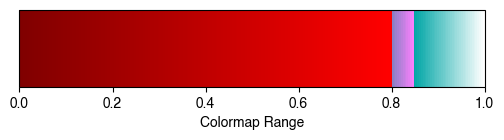

In [23]:
# custom color palette
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors and corresponding positions in the colormap
# colors = [(1, 1, 1), (0, 0.65, 0.65), (1, 0, 0), (0.5, 0, 0)]  # White, Orange, Red, Dark Red
colors = [(0.5, 0, 0), (1, 0, 0), (0.5, 0.5, 0.75), (1, 0.5, 1), (0, 0.65, 0.65), (1, 1, 1)] # Dark Red, Red, Blue, White
positions = [0, 0.8, 0.8, 0.85, 0.85, 1]

# Create the custom colormap
custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors)), N=256)

# Plot a colorbar to visualize the colormap
fig, ax = plt.subplots(figsize=(6, 1))
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=ax, orientation='horizontal')
cbar.set_label('Colormap Range')
plt.show()

In [24]:
def eval_plot_pred(model_name, all_data, preds):
    df_OD_real_daily_flow = all_data.pivot(index="origin", columns="destination", values="daily_flow")
    temp_all_data = all_data.copy()
    temp_all_data["pred_daily_flow"] = preds
    df_OD_pred = temp_all_data.pivot(index="origin", columns="destination", values="pred_daily_flow")
    
    # reorder and create levels for indexes and cols
    df_OD_real_daily_flow = order_matrix_by_counties(df_OD_real_daily_flow)
    df_OD_pred = order_matrix_by_counties(df_OD_pred)
    
    # comparisons:
    diff_pred_real = diff_OD_mat(df_OD_pred, df_OD_real_daily_flow)
    diff_perc_pred_real = diff_OD_mat_perc(df_OD_pred, df_OD_real_daily_flow)
    diff_abs_pred_real = diff_abs_OD_mat(df_OD_pred, df_OD_real_daily_flow)
    GEH_pred_real = diff_geh_OD_mat(df_OD_pred, df_OD_real_daily_flow)
    SQV_pred_real = diff_sqv_OD_mat(df_OD_pred, df_OD_real_daily_flow)
        
    plot_comparisons_2(mats=[df_OD_pred, diff_abs_pred_real, diff_perc_pred_real, SQV_pred_real, df_OD_real_daily_flow],
                     names=['pred {}'.format(model_name), 'absolute diff pred-real', '% diff pred-real', "SQV", 'real daily flows'], 
                     comp_min_val=[-500,-100,0], 
                     comp_max_val=[+500,+100,1], title_txt=model_name)

    return None

In [25]:
def plot_comparisons(mats, names, comp_min_val, comp_max_val, title_txt=""):
    # # Determine the overall minimum and maximum values across all three dataframes
    # global_min = min(np.cbrt(df_OD_pred_no_intervention).values.min(), np.cbrt(df_INE_OD_phase3).values.min())
    # global_max = max(np.cbrt(df_OD_pred_no_intervention).values.max(), np.cbrt(df_INE_OD_phase3).values.max())

    # Define specific tick positions

    # Create subplots with consistent color scale
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 14), sharex=True, sharey=True)

    mats = mats#[df_OD_pred_no_intervention, diff_pred_real, df_INE_OD_phase3]
    names = names#['pred', 'diff pred-real', 'real INE flows']
    im = []
    for i in range(len(mats)):
        if i == 1:
            if "GEH" in title_txt or "SQV" in title_txt: cmap=custom_cmap
            else: cmap = "bwr"
            global_min = comp_min_val #-10
            global_max = comp_max_val # 10
            mat = mats[i]
        else: 
            cmap="Oranges"
            # Determine the overall minimum and maximum values across all three dataframes
            global_min = min(np.log10(mats[0]+1).values.min(), np.log10(mats[-1]+1).values.min())
            global_max = max(np.log10(mats[0]+1).values.max(), np.log10(mats[-1]+1).values.max())
            mat = np.log1p(mats[i])
        name = names[i]
        # Plot Matrix 1
        im.append(axes[i].imshow(mat, cmap=cmap, vmin=global_min, vmax=global_max))
        axes[i].set_title(name)
        axes[i].set_xticks(labels_pos)
        axes[i].set_yticks(labels_pos)
        axes[i].set_xticklabels(mats[0].columns.get_level_values(0)[labels_pos], rotation=45, ha='right')  # Adjust rotation angle and ha
        axes[i].set_yticklabels(mats[0].columns.get_level_values(0)[labels_pos])
        axes[i].axis('on')  # Turn on axis labels
        for pos in ticks_pos:
            axes[i].axvline(pos, color='black', alpha=1)
            axes[i].axhline(pos, color='black', alpha=1)
    
    # Adjust layout
    plt.tight_layout()

    # Create a separate axis for the colorbar
    cbar_ax = fig.add_axes([1, 0.3, 0.01, 0.4])  # Adjust the position and size of the colorbar axis
    cbar_ax_2 = fig.add_axes([1.05, 0.3, 0.01, 0.4])  # Adjust the position and size of the colorbar axis

    # Create a common colorbar with the separate axis
    cbar = fig.colorbar(im[1], cax=cbar_ax)
    cbar_2 = fig.colorbar(im[0], cax=cbar_ax_2)

    plt.suptitle(title_txt, y=0.75)
    
    plt.show()
    return None

In [26]:
def plot_comparisons_2(mats, names, comp_min_val, comp_max_val, title_txt=""):
    # # Determine the overall minimum and maximum values across all three dataframes
    # global_min = min(np.cbrt(df_OD_pred_no_intervention).values.min(), np.cbrt(df_INE_OD_phase3).values.min())
    # global_max = max(np.cbrt(df_OD_pred_no_intervention).values.max(), np.cbrt(df_INE_OD_phase3).values.max())

    # Define specific tick positions

    # Create subplots with consistent color scale
    fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30), sharex=True, sharey=True)

    mats = mats#[df_OD_pred_no_intervention, diff_pred_real, df_INE_OD_phase3]
    names = names#['pred', 'diff pred-real', 'real INE flows']
    im = []
    for i in range(len(mats)):
        name = names[i]
        if i==1 or i==2 or i==3:
            if "GEH" in name or "SQV" in name: cmap=custom_cmap
            else: cmap = "bwr"
            global_min = comp_min_val[i-1] #-10
            global_max = comp_max_val[i-1] # 10
            mat = mats[i]
        else: 
            cmap="Oranges"
            # Determine the overall minimum and maximum values across all three dataframes
            global_min = min(np.log10(mats[0]+1).values.min(), np.log10(mats[-1]+1).values.min())
            global_max = max(np.log10(mats[0]+1).values.max(), np.log10(mats[-1]+1).values.max())
            mat = np.log1p(mats[i])
        
        # Plot Matrix 1
        im.append(axes[i].imshow(mat, cmap=cmap, vmin=global_min, vmax=global_max))
        # axes[i].set_title(name)
        axes[i].set_xticks(labels_pos)
        axes[i].set_yticks(labels_pos)
        axes[i].set_xticklabels(mats[0].columns.get_level_values(0)[labels_pos], rotation=45, ha='right')  # Adjust rotation angle and ha
        axes[i].set_yticklabels(mats[0].columns.get_level_values(0)[labels_pos])
        axes[i].axis('on')  # Turn on axis labels
        for pos in ticks_pos[:-1]:
            axes[i].axvline(pos, color='black', alpha=1)
            axes[i].axhline(pos, color='black', alpha=1)
    
    # Adjust layout
    plt.tight_layout()

    # Create a separate axis for the colorbar
    cbar_ax = fig.add_axes([0.7, 0.55, 0.02, 0.2])  # Adjust the position and size of the colorbar axis
    cbar_ax_2 = fig.add_axes([0.7, 0.3, 0.02, 0.2])  # Adjust the position and size of the colorbar axis

    # Create a common colorbar with the separate axis
    cbar = fig.colorbar(im[1], cax=cbar_ax)
    cbar_2 = fig.colorbar(im[0], cax=cbar_ax_2)

    plt.suptitle(title_txt, y=1.01)
    
    plt.show()
    return None

## Check fits
error metrics

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

# invert a yeojhonson transform for one value
def invert_yeojhonson(value, lmbda):
    if ((value>= 0) and (lmbda == 0)):
        return exp(value) - 1
    elif ((value >= 0) and (lmbda != 0)):
        return (value * lmbda + 1) ** (1 / lmbda) - 1
    elif ((value < 0) and (lmbda != 2)):
        return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
    elif ((value < 0) and (lmbda == 2)):
        return 1 - exp(-value)

def calculate_smape(a, f):
    return 100/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f)))

def calculate_GEH(a, f):
    a = a/12
    f = a/12
    stat = np.sqrt(2*((f-a)**2)/(f+a)).dropna()
    count_below_5 = len(stat[stat<5])
    perc_below_5 = count_below_5*100/len(stat)
    return perc_below_5

def calculate_SQV(c, m):
    f = 10000
    c = c.replace(0, 0.1)
    sqv = 1/(1+np.sqrt(((m-c)**2)/(f*c)))
    # print(sqv)
    sqv = sqv.dropna()
    count_over_085 = len(sqv[sqv.values>0.85])
    perc_over_085 = count_over_085*100/len(sqv)
    sqv.hist()
    return perc_over_085

def custom_scorer_sqv(y_real, y_pred):  
    f = 10000
    c = c.replace(0, 0.1)
    sqv = 1/(1+np.sqrt(((m-c)**2)/(f*c)))
    sqv = sqv.dropna()
    count_over_085 = len(sqv[sqv.values>0.85])
    perc_over_085 = count_over_085*100/len(sqv)
    return perc_over_085

def calculate_cpc(y_real, y_pred):
    numerator = 2 * np.sum(np.minimum(y_real, y_pred))
    denominator = np.sum(y_real) + np.sum(y_pred)
    cpc = numerator / denominator
    return cpc

def calculate_cpl(y_real, y_pred):
    """
    Calculate the Common Part of Links (CPL) metric.
    
    Args:
        y_real (numpy.ndarray): Array of observed number of trips.
        y_pred (numpy.ndarray): Array of predicted number of trips.
        
    Returns:
        float: Common Part of Links (CPL) metric value.
    """
    # Compute the indicator functions for observed and predicted trips
    indicator_real = (y_real > 0).astype(int)
    indicator_pred = (y_pred > 0).astype(int)
    
    # Compute the numerator: sum of products of indicator functions
    numerator = 2 * (indicator_real * indicator_pred).sum()
    
    # Compute the denominators: sum of indicator functions
    denominator = indicator_real.sum() + indicator_pred.sum()
    
    # Compute the CPL metric
    cpl = numerator / denominator
    
    return cpl


def adjusted_r2_score(y_true, y_pred, n_samples, n_features):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - ((1 - r2) * (n_samples - 1)) / (n_samples - n_features - 1)
    return adjusted_r2

def run_metrics(y_true, y_pred, txt, printing=True):
    # Evaluate the whole model
    y_true = y_true.astype("float64")
    y_pred = y_pred.astype("float64")
    r2 =  r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    sqv = calculate_SQV(y_true, y_pred)
    cpc = calculate_cpc(y_true, y_pred)
    cpl = calculate_cpl(y_true, y_pred)
    ratio = y_pred.sum()/y_true.sum()
    if printing:
        print(f'{txt} R-squared: {r2}, MAE: {mae}, RMSE: {rmse}, SQV: {sqv}, RATIO: {ratio}, CPC: {cpc}, CPL: {cpl}\n{r2}\n{mae}\n{rmse}\n{sqv}\n{ratio}\n{cpc}\n{cpl}\n')
    return {"R-squared": r2, "MAE": mae, "RMSE": rmse, "SQV": sqv, "RATIO": ratio, "CPC": cpc, "CPL": cpl}

def r2_plot_regressions(y_true, y_pred):
    # based on https://link.springer.com/article/10.1007/s10640-016-0076-5 and http://proquest.umi.com/pqdweb?did=843587601&Fmt=7&clientId=23852&RQT=309&VName=PQD
    # Predicted values using the linear regression fit
    lr_fit = np.polyfit(np.log1p(y_true), np.log1p(y_pred), 1)
    y_pred_lr = lr_fit[0] * y_true + lr_fit[1]

    # Calculate R²
    r_squared = r2_score(y_true, y_pred_lr)

    # Calculate adjusted R²
    n = len(y_true)
    k = 1  # Assuming you have one independent variable (slope coefficient)
    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

    # Print or use the adjusted R²
    # print(f'R²: {r_squared}, Adjusted R²: {adjusted_r_squared}')
    return r_squared, adjusted_r_squared

def calculate_mst(y_train, y_test):
    n = len(y_test)
    y_train_mean = np.mean(y_train)
    mst = np.sum((y_test - y_train_mean)**2) / n
    return mst

def calculate_out_of_sample_r2(y_train, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mst = calculate_mst(y_train, y_test)
    out_of_sample_r2 = 1 - mse / mst
    return out_of_sample_r2
    
def compute_ratio(y_true, y_pred):
    return abs(y_pred.sum)

# with scaled/transformed variables
def check_fit(model, data, features, target, model_type=False):
    X_manual = data[features]
    y_manual = data[target]
    
    # test split
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    if model_type=="hurdle":
        print("using Hurdle")
        dmat_manual = xgb.DMatrix(X_manual, y_manual)
        y_pred_all = predict_expected_value_strat_1(X_manual, dmat_manual, model[0], model[1])
    elif model_type=="mixed_1":
        print("using mixed_1")
        y_pred_all = predict_expected_value_mixed_1(X_manual, model[0], model[1])
    else: y_pred_all = model.predict(X_manual)
    y_pred_train, y_pred_test, y_train, y_test = train_test_split(y_pred_all, y_manual, test_size=0.2, random_state=42)
    
    # Evaluate the model on test
    run_metrics(y_test, y_pred_test, "TRANSFORMED OUT OF SAMPLE METRICS (test set): ")
    
    # Evaluate the model on train
    run_metrics(y_train, y_pred_train, "TRANSFORMED IN SAMPLE METRICS (train set): ")
    
    # Evaluate the model on ALL DATA
    run_metrics(y_manual, y_pred_all, "TRANSFORMED ALL DATA METRICS: ")

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_manual,y_pred_all, s=5, alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial
    lr_fit = np.polyfit(y_manual, y_pred_all, 1)
    plt.plot(y_manual, lr_fit[0] * y_manual + lr_fit[1], color='r')
    plt.title('ALL DATA y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)
    
    lr_fit_train = np.polyfit(y_train, y_pred_train, 1)
    plt.plot(y_train, lr_fit_train[0] * y_train + lr_fit_train[1], color='g', lw=0.5)
    print('TRAIN y={:.2f}+{:.2f}*x'.format(lr_fit_train[1], lr_fit_train[0]))
    
    lr_fit_test = np.polyfit(y_test, y_pred_test, 1)
    # r2, r2_adj = r2_plot_regressions(y_rescaled_test, y_pred_duan_test)
    plt.plot(y_test, lr_fit_test[0] * y_test + lr_fit_test[1], color='c', lw=0.5)
    print('TEST y={:.2f}+{:.2f}*x')#, R2: {}, adj-R2: {}'.format(lr_fit_test[1], lr_fit_test[0], r2, r2_adj))

    # Add vertical and horizontal lines at 0,0
    ax.axvline(0, color='gray', linestyle='--')
    ax.axhline(0, color='gray', linestyle='--')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    return y_pred_all

# rescaling / untransforming variables
def check_fit_rescale(model, data, features, target, model_type=False):
    X_manual = data[features]
    y_manual = data[target]
    
    # test split
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    if model_type=="hurdle":
        print("using Hurdle")
        dmat_manual = xgb.DMatrix(X_manual, y_manual)
        y_pred_all = predict_expected_value_strat_1(X_manual, dmat_manual, model[0], model[1])
    elif model_type=="mixed_1":
        print("using mixed_1")
        y_pred_all = predict_expected_value_mixed_1(X_manual, model[0], model[1])
    else: y_pred_all = model.predict(X_manual)
    y_pred_train, y_pred_test, y_train, y_test = train_test_split(y_pred_all, y_manual, test_size=0.2, random_state=42)
    
    trans = target.split("_")[0]

    # Back transform
    if trans=="log": 
        y_test, y_pred_test = np.expm1(y_test), np.expm1(y_pred_test)
        y_train, y_pred_train = np.expm1(y_train), np.expm1(y_pred_train)
        y_manual, y_pred_all = np.expm1(y_manual), np.expm1(y_pred_all)
    elif trans=="cbrt":
        y_test, y_pred_test =y_test**3, y_pred_test**3
        y_train, y_pred_train =y_train**3, y_pred_train**3
        y_manual, y_pred_all =y_manual**3, y_pred_all**3
    elif trans=="rec": 
        y_test, y_pred_test = (1-y_test)/y_test, (1-y_pred_test)/y_pred_test
        y_train, y_pred_train = (1-y_train)/y_train, (1-y_pred_train)/y_pred_train
        y_manual, y_pred_all = (1-y_manual)/y_manual, (1-y_pred_all)/y_pred_all
    elif trans=="sqrt": 
        y_test, y_pred_test = y_test**2, y_pred_test**2
        y_train, y_pred_train =y_train**2, y_pred_train**2
        y_manual, y_pred_all =y_manual**2, y_pred_all**2

    # Evaluate the model on test
    # y_pred_test = model.predict(X_test)
    run_metrics(y_test, y_pred_test, "BACK-TRANSFORMED (ORIGINAL SCALE) OUT OF SAMPLE METRICS (test set): ")
    print("OSR2: ",calculate_out_of_sample_r2(y_train, y_test, y_pred_test), '\n')
    print("adjR2:", adjusted_r2_score(y_test, y_pred_test, len(y_test), len(features)))
    
    # Evaluate the model on train
    run_metrics(y_train, y_pred_train, "BACK-TRANSFORMED (ORIGINAL SCALE) IN SAMPLE METRICS (train set): ")
    
    # Evaluate the model on ALL DATA
    run_metrics(y_manual, y_pred_all, "BACK-TRANSFORMED (ORIGINAL SCALE) ALL DATA METRICS: ")

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_manual,y_pred_all, s=5, alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial
    lr_fit = np.polyfit(y_manual, y_pred_all, 1)
    plt.plot(y_manual, lr_fit[0] * y_manual + lr_fit[1], color='r')
    plt.title('ALL DATA y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)
    
    lr_fit_train = np.polyfit(y_train, y_pred_train, 1)
    plt.plot(y_train, lr_fit_train[0] * y_train + lr_fit_train[1], color='g', lw=0.5)
    print('TRAIN y={:.2f}+{:.2f}*x'.format(lr_fit_train[1], lr_fit_train[0]))
    
    lr_fit_test = np.polyfit(y_test, y_pred_test, 1)
    r2, r2_adj = r2_plot_regressions(y_test, y_pred_test)
    plt.plot(y_test, lr_fit_test[0] * y_test + lr_fit_test[1], color='c', lw=0.5)
    print('TEST y={:.2f}+{:.2f}*x, R2: {}, adj-R2: {}'.format(lr_fit_test[1], lr_fit_test[0], r2, r2_adj))

    # plt.text(5, 15, 'R-squared = %0.2f' % r2)
    ax.set_ylim(-5000, 50000)
    ax.set_xlim(-5000, 50000)
    # Add vertical and horizontal lines at 0,0
    ax.axvline(0, color='gray', linestyle='--')
    ax.axhline(0, color='gray', linestyle='--')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    
    
    ### zoom 
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_manual,y_pred_all, s=5, alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial
    lr_fit = np.polyfit(y_manual, y_pred_all, 1)
    plt.plot(y_manual, lr_fit[0] * y_manual + lr_fit[1], color='r')
    plt.title('ALL DATA y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)
    
    lr_fit_train = np.polyfit(y_train, y_pred_train, 1)
    plt.plot(y_train, lr_fit_train[0] * y_train + lr_fit_train[1], color='g', lw=0.5)
    print('TRAIN y={:.2f}+{:.2f}*x'.format(lr_fit_train[1], lr_fit_train[0]))
    
    lr_fit_test = np.polyfit(y_test, y_pred_test, 1)
    r2, r2_adj = r2_plot_regressions(y_test, y_pred_test)
    plt.plot(y_test, lr_fit_test[0] * y_test + lr_fit_test[1], color='c', lw=0.5)
    print('TEST y={:.2f}+{:.2f}*x, R2: {}, adj-R2: {}'.format(lr_fit_test[1], lr_fit_test[0], r2, r2_adj))

    ax.set_ylim(-1, 100)
    ax.set_xlim(-1, 100)
    # Add vertical and horizontal lines at 0,0
    ax.axvline(0, color='gray', linestyle='--')
    ax.axhline(0, color='gray', linestyle='--')
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    
    return y_pred_all

# rescaling / untransforming variables using Duan Smearing approach
def check_fit_duan_smearing_non_param(model, data, features, target, n_sample=1000, model_type=False): #https://andrewpwheeler.com/tag/linear-regression/
    np.random.seed(seed=42)
    X = data[features]
    y = data[target]
    
    # # test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    
    # predicting whole data based on training
    if model_type=="hurdle":
        print("using Hurdle")
        dmat_manual = xgb.DMatrix(X_manual, y_manual)
        y_pred_all = predict_expected_value_strat_1(X, dmat_manual, model[0], model[1])
    elif model_type=="mixed_1":
        print("using mixed_1")
        y_pred_all = predict_expected_value_mixed_1(X, model[0], model[1])
    else: y_pred_all = model.predict(X)
    
    
    if target.split("_")[0]=="yj": #compute lambda
        transformed_, lam = yeojohnson(data[target[3:]])
    
    # backtransforming all dependet variable
    y_rescaled = data["daily_flow"]
    
    if target.split("_")[0]=="log":
        # y_pred_test_rescaled_wrong = np.expm1(y_pred_test) # y_pred from train wrongly_trans
        y_test_rescaled = np.expm1(y_test) # y_train rescaled real data TRAIN
    elif target.split("_")[0]=="cbrt":
        # y_pred_test_rescaled_wrong = y_pred_test**3 # y_pred from train wrongly_trans
        y_test_rescaled = y_test**3 # y_train rescaled real data TRAIN
    elif target.split("_")[0]=="sqrt":
        # y_pred_test_rescaled_wrong = y_pred_test**2 # y_pred from train wrongly_trans
        y_test_rescaled = y_test**2 # y_train rescaled real data TRAIN
    elif target.split("_")[0]=="yj":
        # y_pred_test_rescaled_wrong = inv(y_pred_test, lam) # y_pred from train wrongly_trans
        y_test_rescaled = invert_yeojhonson(y_test, lam) # y_train rescaled real data TRAIN
    elif target.split("_")[0]=="rec": 
        # y_pred_test_rescaled_wrong = (1-y_pred_test)/y_pred_test # y_pred from train wrongly_trans
        y_test_rescaled = (1-y_test)/y_test # y_train rescaled real data TRAIN
    
    n_all = len(y)
    n_train = len(y_train)
    n_test = len(y_test)
    
    ######################################################
    # Duan's smearing, non-parametric approach via residuals


    resids = y - y_pred_all # y is transformed already. Resids transformed too.
    resids = resids.values.reshape(1,n_all)
    # resids = np.random.choice(resids, n_sample)
    rng = np.random.default_rng(42)
    resids = rng.choice(resids, n_sample, axis=1)
    # resids = resids.reshape(1,n_sample)
    
    ## apply Duan Smearing to entire dataset
    if target.split("_")[0]=="log":
        dp = inv_f(y_pred_all.reshape(n_all,1) + resids) # adjust in the whole dataset from the estimated in train
    elif target.split("_")[0]=="cbrt":
        dp = (y_pred_all.reshape(n_all,1) + resids)**3 # adjust in the whole dataset from the estimated in train
    elif target.split("_")[0]=="sqrt":
        dp = (y_pred_all.reshape(n_all,1) + resids)**2 # adjust in the whole dataset from the estimated in train
    elif target.split("_")[0]=="yj":
        dp = invert_yeojhonson(y_pred_all.reshape(n_all,1) + resids, lam) # adjust in the whole dataset from the estimated in train
    elif target.split("_")[0]=="rec": 
        dp = (1-(y_pred_all.reshape(n_all,1) + resids))/(y_pred_all.reshape(n_all,1) + resids)
    y_pred_duan = pd.Series(dp.mean(axis=1))
    
    # split train and test again with smearing
    y_rescaled_train, y_rescaled_test, y_pred_duan_train, y_pred_duan_test = train_test_split(y_rescaled, y_pred_duan, test_size=0.2, random_state=42)
    
    # Evaluate the model on test
    run_metrics(y_rescaled_test, y_pred_duan_test, "BACK-TRANSFORMED w/SMEARING (ORIGINAL SCALE) OUT OF SAMPLE METRICS (test set): ")
    print("OSR2: ",calculate_out_of_sample_r2(y_rescaled_train, y_rescaled_test, y_pred_duan_test), '\n')
    
    # Evaluate the model on train
    run_metrics(y_rescaled_train, y_pred_duan_train, "BACK-TRANSFORMED w/SMEARING (ORIGINAL SCALE) IN SAMPLE METRICS (train set): ")
    
    # Evaluate the model on ALL DATA
    run_metrics(y_rescaled, y_pred_duan, "BACK-TRANSFORMED w/SMEARING (ORIGINAL SCALE) ALL DATA METRICS: ")

    ######################################################
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_rescaled, y_pred_duan, s=1, alpha=0.1)
    plt.scatter(y_test_rescaled, y_pred_duan_test, s=2, c="r", alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial
    lr_fit = np.polyfit(y_rescaled, y_pred_duan, 1)
    plt.plot(y_rescaled, lr_fit[0] * y_rescaled + lr_fit[1], color='r')
    plt.title('ALL DATA y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)
    
    lr_fit_train = np.polyfit(y_rescaled_train, y_pred_duan_train, 1)
    plt.plot(y_rescaled_train, lr_fit_train[0] * y_rescaled_train + lr_fit_train[1], color='g', lw=0.5)
    print('TRAIN y={:.2f}+{:.2f}*x'.format(lr_fit_train[1], lr_fit_train[0]))
    
    lr_fit_test = np.polyfit(y_rescaled_test, y_pred_duan_test, 1)
    r2, r2_adj = r2_plot_regressions(y_rescaled_test, y_pred_duan_test)
    plt.plot(y_rescaled_test, lr_fit_test[0] * y_rescaled_test + lr_fit_test[1], color='c', lw=0.5)
    print('TEST y={:.2f}+{:.2f}*x, R2: {}, adj-R2: {}'.format(lr_fit_test[1], lr_fit_test[0], r2, r2_adj))


    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    ax.set_ylim(-0, 10)
    ax.set_xlim(-0, 10)
    # Add vertical and horizontal lines at 0,0
    ax.axvline(0, color='gray', linestyle='--')
    ax.axhline(0, color='gray', linestyle='--')
    plt.show()
    return y_pred_duan

In [28]:
tt = TransformedTargetRegressor(regressor=LinearRegression(),
                                func=np.log1p, inverse_func=np.expm1)
f = tt.get_params()['func']              #function
inv_f = tt.get_params()['inverse_func']  #and inverse function

### bootstrapping for stability analysis

In [31]:
import numpy as np
from sklearn.utils import resample
import xgboost as xgb

def ranges_from_bootstrapping(model_type, features, target, data, model, two_part_model=False, num_bootstrap_samples=10):
                                 
    # y_pred_train, y_pred_test, y_train, y_test = train_test_split(y_pred_all, y_manual, test_size=0.2, random_state=42)
    
    features = assemble_features(model_type, features, target)

    X_manual = data_[features]
    y_manual = data_[target]

    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    # Array to store combined predictions from each bootstrap sample
    bootstrap_predictions = np.zeros((num_bootstrap_samples, len(X_test)))
    
    df_results = pd.DataFrame()
    
    for i in range(num_bootstrap_samples):
        # Create bootstrap samples
        bootstrap_indices = resample(np.arange(len(X_test)))
        X_bootstrap = X_test.iloc[bootstrap_indices]
        y_bootstrap = y_test.iloc[bootstrap_indices]

        
        if two_part_model=="hurdle":
            # print("using Hurdle")
            dmat_manual = xgb.DMatrix(X_bootstrap, y_bootstrap)
            y_pred_bootstrap = predict_expected_value_strat_1(X_bootstrap, dmat_manual, model[0], model[1])
        elif two_part_model=="mixed_1":
            # print("using mixed_1")
            y_pred_bootstrap = predict_expected_value_mixed_1(X_bootstrap, model[0], model[1])
        else: y_pred_bootstrap = model.predict(X_bootstrap)

        if i%10==0: print("iteration:", i)
        
        dict_partial_results = run_metrics(y_bootstrap**2, y_pred_bootstrap**2, f"bootstrap {i}", printing=False)
        df_results = pd.concat([df_results, pd.DataFrame([dict_partial_results])])
    
    
    return df_results

# Modeling

selecting features based on the specifications for spatial interactions

In [29]:
def assemble_features(model_type, features, target): 
    w = "Wq_R_"
    
    features_trans = features[0].split("_")[0]+"_"
    if features_trans == "cbrt_" or features_trans == "log_" or features_trans == "yj_" or features_trans == "sqrt_": features_trans = features_trans
    else: features_trans = ""
    
    target_trans = target.split("_")[0]+"_"
    if target_trans == "cbrt_" or target_trans == "log_" or target_trans == "yj_" or target_trans == "sqrt_": target_trans = target_trans
    else: target_trans = ""
    
    features = features
    if model_type == "SDM" or model_type == "SLX" or model_type == "SLX_simpler":
        print("MODEL TYPE:", model_type)
        lagged_features = [variable.replace("o_",f"{w}o_").replace("d_",f"{w}d_") if variable.startswith("o_") or variable.startswith("d_") else variable for variable in features]# if "traveltime" not in variable] 
        lagged_features = [variable.replace(f"{features_trans}", f"{features_trans}{w}") if w not in variable and features_trans!="" else variable for variable in lagged_features] # for interactions
        
        if model_type == "SLX_simpler": # remove weighted interactions terms for no
            o_d_lagged_features =[]
            for variable in lagged_features:
                if (f"{w}o_" in variable) or (f"{w}d_" in variable):
                    o_d_lagged_features.append(variable)
            lagged_features = o_d_lagged_features

        
        if model_type == "SDM":
            lagged_features = lagged_features + [f"{target_trans}Wq_R_o_daily_flow"] + [f"{target_trans}Wq_R_d_daily_flow"] + [f"{target_trans}Wq_R_od_daily_flow"]
        features = features + lagged_features
    elif model_type == "SAR":
        lagged_features = [f"{target_trans}Wq_R_o_daily_flow"] + [f"{target_trans}Wq_R_d_daily_flow"] + [f"{target_trans}Wq_R_od_daily_flow"]
        features = features + lagged_features
    elif model_type == "SAR_o":
        lagged_features = [f"{target_trans}Wq_R_o_daily_flow"]
        features = features + lagged_features
    elif model_type == "SAR_d":
        lagged_features = [f"{target_trans}Wq_R_d_daily_flow"]
        features = features + lagged_features
    elif model_type == "SAR_w":
        lagged_features = [f"{target_trans}Wq_R_od_daily_flow"]
        features = features + lagged_features
    else: features = features
    print(features)
    return features

## Models

### Regular OLS model

In [73]:
from sklearn.linear_model import LinearRegression

def run_model_ols(model_type, features, target, print_output=True):
    transformation = ""

    # features = vars_c_10007_log #sel_vars_10010_log
    # target = f"sqrt_daily_flow"
    data_ = all_data.drop(["o_geometry", "d_geometry"], axis=1).astype("float64")
    
    features = assemble_features(model_type, features, target)
    
    X_manual = data_[features]
    y_manual = data_[target]

    # OLS model
    if print_output:
        m = spreg.OLS(
        data_[target].values,
        data_[features].values,
        name_y = target,
        name_x = list(data_[features].columns), 
        )
        print(m.summary)
    
        for val in m.betas:#t_stat:
            print(val[0])
    
        for val in m.t_stat:
            print(val[1])
    
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    m = LinearRegression().fit(X_train, y_train)

    #check
    y_pred = check_fit(m, data_, features, target)
    
    if target.split("_")[0] == "cbrt" or target.split("_")[0] == "log" or target.split("_")[0] == "sqrt":
        y_pred = check_fit_rescale(m, data_, features, target)
    else:
        plot_hist(data_, y_pred)

    test_results = ranges_from_bootstrapping(model_type=model_type, 
                              features=vars_c_10007_log, 
                              target="sqrt_daily_flow", 
                              data=all_data, 
                              model=m, 
                              two_part_model=False, 
                              num_bootstrap_samples=100)
    return test_results, m, y_pred


### XGBoost

In [75]:
%%time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# Assuming your dataset is in a DataFrame named 'df' with columns ['independent_var1', 'independent_var2', 'independent_var3', 'independent_var4', 'cbrt_daily_flows']
# You may need to replace these column names with the actual names in your dataset.

# # Step 1: Polynomial Regression
# X_manual = all_data[selected_vars_501]
# y_manual = all_data['cbrt_daily_flow']

def poly_xgb_rfecv(X_manual, y_manual, degree, learning_rate=0.3, alpha=0, reg_lambda=1):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)

    # Fit a polynomial regression model
    # degree = 2  # You can adjust the degree of the polynomial
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)

    # Step 2: Recursive Feature Selection with XGBoost
    xgb = XGBRegressor(device="gpu", 
                       # learning_rate=learning_rate,
                       alpha=alpha, 
                       reg_lambda=reg_lambda, 
                       verbosity=0)

    # Initialize RFECV
    selector = RFECV(estimator=xgb, step=1, cv=5, n_jobs=-1, scoring='r2')

    # Fit RFECV
    selector = selector.fit(X_poly_train, y_train)

    # Select the best features
    X_poly_train_selected = selector.transform(X_poly_train)
    X_poly_test_selected = selector.transform(X_poly_test)

    # Train a new XGBoost model with selected features
    xgb_selected = XGBRegressor(device="gpu", 
                                # learning_rate=learning_rate,
                                alpha=alpha, 
                                reg_lambda=reg_lambda, 
                                verbosity=0)
    xgb_selected.fit(X_poly_train_selected, y_train)

    # Make predictions on the test set
    y_pred = xgb_selected.predict(X_poly_test_selected)

    # Evaluate the model
    r2 = r2_score(y_test, y_pred)
    print(f'R2 Score: {r2}')

    # Get the selected features
    selected_features = np.array(poly.get_feature_names_out(X_manual.columns))[selector.support_]

    print("Selected Features:")#, selected_features)
    plot_results_poly_xgb_rfecv(xgb_selected, selected_features)
    summary_df = coeff_df_poly_xgb_rfecv(X_manual, poly, selector, xgb_selected)
    
    return xgb_selected, summary_df


import matplotlib.pyplot as plt
def plot_results_poly_xgb_rfecv(xgb_selected, selected_features):
    # Plot the coefficients of the polynomial model
    coefficients = xgb_selected.feature_importances_

    # Create a bar plot
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(coefficients)), coefficients)
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.title('Polynomial Model Coefficients')
    plt.xticks(range(len(selected_features)), selected_features, rotation=90)
    plt.show()
    return None
    

def coeff_df_poly_xgb_rfecv(X_manual, poly, selector, xgb_selected):
    # Get the feature names and coefficients
    feature_names = poly.get_feature_names_out(X_manual.columns)[selector.support_]
    coefficients = xgb_selected.feature_importances_

    # Create a DataFrame to store the summary
    summary_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

    # Display the summary
    display(summary_df)
    return summary_df

CPU times: user 26 μs, sys: 2 μs, total: 28 μs
Wall time: 31.9 μs


In [76]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from cuml.preprocessing import PolynomialFeatures as cuPolynomialFeatures
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as sklearn_mse, r2_score as sklearn_r2

def test_gpu(X, y):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Polynomial features with CPU
    poly = PolynomialFeatures(degree=3)
    X_poly_cpu = poly.fit_transform(X_train)

    # Polynomial features with GPU (using cuDF)
    X_cudf = pd.DataFrame(X_train)  # Convert to Pandas DataFrame
    X_gpu = cuPolynomialFeatures(degree=3).fit_transform(X_cudf)
    X_poly_gpu = X_gpu.values

    # XGBoost with CPU data
    xgb_model_cpu = xgb.XGBRegressor(n_estimators=100, alpha=0.25, tree_method='hist')
    xgb_model_cpu.fit(X_poly_cpu, y_train)
    y_pred_cpu = xgb_model_cpu.predict(poly.transform(X_test))

    # XGBoost with GPU data
    xgb_model_gpu = xgb.XGBRegressor(n_estimators=100, alpha=0.25, tree_method='gpu_hist')
    xgb_model_gpu.fit(X_poly_gpu, y_train)
    y_pred_gpu = xgb_model_gpu.predict(cuPolynomialFeatures(degree=3).fit_transform(pd.DataFrame(X_test)).values)

    # Random Forest with GPU (using cuML)
    rf_model_gpu = RandomForestRegressor(n_estimators=100)
    rf_model_gpu.fit(X_cudf, y_train)
    y_pred_rf_gpu = rf_model_gpu.predict(pd.DataFrame(X_test))

    # Evaluate models
    mse_cpu = sklearn_mse(y_test, y_pred_cpu)
    r2_cpu = sklearn_r2(y_test, y_pred_cpu)

    mse_gpu_xgb = mean_squared_error(y_test, y_pred_gpu)
    r2_gpu_xgb = r2_score(y_test, y_pred_gpu)

    mse_gpu_rf = mean_squared_error(y_test, y_pred_rf_gpu)
    r2_gpu_rf = r2_score(y_test, y_pred_rf_gpu)

    print(f'MSE (XGBoost, CPU): {mse_cpu}, R-squared (XGBoost, CPU): {r2_cpu}')
    print(f'MSE (XGBoost, GPU): {mse_gpu_xgb}, R-squared (XGBoost, GPU): {r2_gpu_xgb}')
    print(f'MSE (Random Forest, GPU): {mse_gpu_rf}, R-squared (Random Forest, GPU): {r2_gpu_rf}')
    
def simple_test_gpu(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Polynomial features with GPU (using cuDF)
    X_cudf = pd.DataFrame(X_train)  # Convert to Pandas DataFrame
    X_gpu = cuPolynomialFeatures(degree=3).fit_transform(X_cudf)
    X_poly_gpu = X_gpu.values

    # XGBoost with GPU data
    xgb_model_gpu = xgb.XGBRegressor(n_estimators=100, alpha=0.25, tree_method='gpu_hist')
    xgb_model_gpu.fit(X_poly_gpu, y_train)
    y_pred_gpu = xgb_model_gpu.predict(cuPolynomialFeatures(degree=3).fit_transform(pd.DataFrame(X_test)).values)

    # Random Forest with GPU (using cuML)
    rf_model_gpu = RandomForestRegressor(n_estimators=100)
    rf_model_gpu.fit(X_cudf, y_train)
    y_pred_rf_gpu = rf_model_gpu.predict(pd.DataFrame(X_test))

    # Evaluate models

    mse_gpu_xgb = mean_squared_error(y_test, y_pred_gpu)
    r2_gpu_xgb = r2_score(y_test, y_pred_gpu)

    mse_gpu_rf = mean_squared_error(y_test, y_pred_rf_gpu)
    r2_gpu_rf = r2_score(y_test, y_pred_rf_gpu)
    
    print(f'MSE (XGBoost, GPU): {mse_gpu_xgb}, R-squared (XGBoost, GPU): {r2_gpu_xgb}')
    print(f'MSE (Random Forest, GPU): {mse_gpu_rf}, R-squared (Random Forest, GPU): {r2_gpu_rf}')

    #Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    Y_actual = Y_actual**3
    Y_Predicted = Y_Predicted**3
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [77]:
def xgb_07(X, y, **params
          ):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # XGBoost with GPU data
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

   # Evaluate the model on test
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    
    print(f'test set R-squared: {r2}, MAE: {mae}, RMSE: {rmse}\n{r2}\n{mae}\n{rmse}')
    return xgb_model

In [78]:
def check_fit_xgb(model, data, features, target):
    ## check R2 only for the core area (all_data_RONDES)

    X_manual = data[features]
    X_cudf_manual = pd.DataFrame(X_manual)
    X_manual_gpu = cuPolynomialFeatures(degree=1).fit_transform(X_cudf_manual)
    y_manual = data[target]
    pred = model.predict(X_manual)

    # Evaluate the whole model
    r2 =  r2_score(y_manual, pred)
    mae = mean_absolute_error(y_manual, pred)
    rmse = root_mean_squared_error(y_manual, pred)
    
    print(f'ALL DATA R-squared: {r2}, MAE: {mae}, RMSE: {rmse}\n{r2}\n{mae}\n{rmse}')

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_manual,pred, s=5, alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial - males
    lr_fit = np.polyfit(y_manual, pred, 1)
    plt.plot(y_manual, lr_fit[0] * y_manual + lr_fit[1], color='r')
    plt.text(5, 10, 'y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)

    # plt.text(5, 15, 'R-squared = %0.2f' % r2)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    
def check_fit_xgb_rescale(model, data, features, target, trans):
    X_manual = data[features]
    y_manual = data[target]
    
    # test split
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    y_pred = model.predict(X_test)
    
    # Back transform
    if trans=="log": y_test, y_pred = np.expm1(y_test), np.expm1(y_pred)
    elif trans=="cbrt": y_test, y_pred =y_test**3, y_pred**3

    # Evaluate the model on test
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    smape = calculate_smape(y_test, y_pred)
    print(f'test set rescaled R-squared: {r2}, MAE: {mae}, RMSE: {rmse}, SMAPE: {smape}\n{r2}\n{mae}\n{rmse}\n{smape}')
    
    pred = model.predict(X_manual)
    # Back transform entire model
    if trans=="log": y_manual, pred = np.expm1(y_manual), np.expm1(pred)
    elif trans=="cbrt": y_manual, pred =y_manual**3, pred**3
    # Evaluate the whole model
    r2 =  r2_score(y_manual, pred)
    mae = mean_absolute_error(y_manual, pred)
    rmse = root_mean_squared_error(y_manual, pred)
    smape = calculate_smape(y_manual, pred)
    
    print(f'ALL DATA rescaled R-squared: {r2}, MAE: {mae}, RMSE: {rmse} SMAPE: {smape}\n{r2}\n{mae}\n{rmse}\n{smape}')

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_manual,pred, s=5, alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial - males
    lr_fit = np.polyfit(y_manual, pred, 1)
    plt.plot(y_manual, lr_fit[0] * y_manual + lr_fit[1], color='r')
    plt.text(5, 10, 'y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)

    # plt.text(5, 15, 'R-squared = %0.2f' % r2)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.show()
    
def check_fit_xgb_gpu(model, data, features, target):
    ## check R2 only for the core area (all_data_RONDES)

    X_manual = data[features]
    X_cudf_manual = pd.DataFrame(X_manual)
    X_manual_gpu = cuPolynomialFeatures(degree=1).fit_transform(X_cudf_manual)
    y_manual = data[target]
    pred = model.predict(X_manual_gpu)

    # Evaluate the stacking model
    r_squared =  r2_score(y_manual, pred)
    print("XGB R2:",r_squared)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    plt.scatter(y_manual,pred, s=5, alpha=0.1)
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    
    # fit
    # polynomial - males
    lr_fit = np.polyfit(y_manual, pred, 1)
    plt.plot(y_manual, lr_fit[0] * y_manual + lr_fit[1], color='r')
    plt.text(5, 10, 'y={:.2f}+{:.2f}*x'.format(lr_fit[1], lr_fit[0]), color='r', size=12)

    plt.text(5, 15, 'R-squared = %0.2f' % r_squared)
    plt.show()
    


#### single Tweedie regression XGB model

In [80]:
def run_model_xgb(model_type, features, target, hurdle=False, print_output=False):
    transformation = ""

    # features = vars_c_10007_log #sel_vars_10010_log
    # target = f"sqrt_daily_flow"
    
    if hurdle: data_ = all_data[all_data.daily_flow>=0.5].drop(["o_geometry", "d_geometry"], axis=1).astype("float64")
    else: data_ = all_data.drop(["o_geometry", "d_geometry"], axis=1).astype("float64")
    
    features = assemble_features(model_type, features, target)
    
    X_manual = data_[features]
    y_manual = data_[target]

    xgb_params = {
    "n_estimators": 3495, 
    "objective": "reg:tweedie", 
    "tweedie_variance_power": 1.5239438240774885
    }

    m = xgb_07(X_manual, y_manual, **xgb_params)

    #check
    y_pred = check_fit(m, data_, features, target)
    
    if target.split("_")[0] == "cbrt" or target.split("_")[0] == "log" or target.split("_")[0] == "sqrt":
        y_pred = check_fit_rescale(m, data_, features, target)
    else:
        plot_hist(data_, y_pred)

    test_results = ranges_from_bootstrapping(model_type=model_type, 
                              features=vars_c_10007_log, 
                              target="sqrt_daily_flow", 
                              data=all_data, 
                              model=m, 
                              two_part_model=False, 
                              num_bootstrap_samples=100)
    return test_results, m, y_pred


#### Logistic regression for predicting zeroes

In [89]:
# logistic regression for checking if y == 0

def confusion_matrix_binary_model(binary_model, X_test, y_test):
    y_pred = binary_model.predict(X_test)
    y_actual = pd.Series(y_test.values, name='Actual')
    y_predicted = pd.Series(y_pred, name='Predicted')

    #create confusion matrix
    display(pd.crosstab(y_actual, y_predicted))
    
    return None


def run_logistic_model_xgb(model_type, features, target, print_output=False):    
    X_manual = data_[features]
    y_manual = data_[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    xgb_clf_params = {
     'booster': 'gbtree',
        "learning_rate": 0.021455828509776516,
        "lambda": 0.5513728727048264,
        "alpha": 5.887724735535364e-05,
        "max_depth": 12,
        "min_child_weight": 7,
        "gamma": 0.00026597538061527666,
        "grow_policy": "depthwise",
        'objective': 'binary:logistic',
        'n_estimators': 2000
    }
    
    xgb_binaire = xgb.XGBClassifier(**xgb_clf_params)
    
    xgb_binaire.fit(X=X_train, y=y_train>0, 
                    eval_set=[(X_train, y_train>0), (X_test, y_test>0)],
                    eval_metric=["logloss"], verbose=100, 
                    early_stopping_rounds=15
                          )
    
    
    X_manual = data_[features]
    y_manual = data_["non_zero"]
    
    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    confusion_matrix_binary_model(xgb_binaire, X_test, y_test)

    return xgb_binaire

#### Hurdle model
https://medium.com/@krasniqi.dafnis/hurdle-model-with-xgboost-part-2-e55cea86e05a

##### helpers

In [86]:
from typing import Tuple, Dict, List

def first_grad(predt, dtrain):
    '''Compute the first derivative.'''
    y = dtrain.get_label() if isinstance(dtrain, xgb.DMatrix) else dtrain
    return (-y/predt) +(np.exp(predt)/(np.exp(predt)-1))

def second_grad(predt, dtrain):
    '''Compute the second derivative.'''
    y = dtrain.get_label() if isinstance(dtrain, xgb.DMatrix) else dtrain
    return (y/predt**2 - (np.exp(predt)/(np.exp(predt)-1)**2)) 

def PoissonZeroNegLogLik(predt, dtrain):
    ''''Mean squared error function.'''
    predt[predt < 0] = 0 + 1e-6
    grad = first_grad(predt, dtrain)
    hess = second_grad(predt, dtrain)
    return grad, hess

def EvalPoissonZeroNegLogLik(preds: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    actuals = dtrain.get_label()
    preds[preds < 0] = 1e-6
    resultats = -actuals * np.log(preds) + np.log(np.exp(preds)-1)
    return "ZIdev", float(np.sum(resultats)/len(preds))

In [87]:
def predict_expected_value_strat_1(X_b, X_p, xgb_B, xgb_P):
    output_B = xgb_B.predict(X_b)
    output_P = xgb_P.predict(X_p)
    output_P_ = ((output_P*np.exp(output_P))/(np.exp(output_P)-1))
    
    return output_B*output_P_   

def predict_expected_value_mixed_1(X, xgb_B, xgb_P):
    output_B = xgb_B.predict(X)
    output_P = xgb_P.predict(X)  
    return output_B*output_P    

##### Hurdle model

In [90]:
def run_model_hurdle(model_type, features, target, print_output=True):
    transformation = ""

    # features = vars_c_10007_log
    # target = f"sqrt_daily_flow"
    data_ = all_data.drop(["o_geometry", "d_geometry"], axis=1).astype("float64")
    
    features = assemble_features(model_type, features, target)
    
    X_manual = data_[features]
    y_manual = data_[target]

    # for values == 0:
    model_logistic_reg = run_logistic_model_xgb(model_type, features, target)
    # for values > 0:
    _ , model_non_zero_reg, _ = run_model_xgb(model_type, hurdle=True, print_output=False)

    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)
    
    y_pred = check_fit((model_logistic_reg, model_non_zero_reg), data_, features, target, model_type="mixed_1")
    
    if target.split("_")[0] == "cbrt" or target.split("_")[0] == "log" or target.split("_")[0] == "sqrt":
        y_pred = check_fit_rescale((model_logistic_reg, model_non_zero_reg), data_, features, target,  model_type="mixed_1")
        # duan_smearing_non_param_train_test(m_1, data_, features, target)
        y_pred_duan = check_fit_duan_smearing_non_param((model_logistic_reg, model_non_zero_reg), data_, features, target, 10000,  model_type="mixed_1")
        # plot_importance_lgb(m_1)
    
        eval_plot_pred("mixed_1_10007_log-sqrt OPTIMIZED", all_data, y_pred)
        # eval_plot_pred("LGBLightSLX_10007_log-sqrt_linearTree-DUAN SMEARING", all_data, y_pred_duan)
        plot_hist(data_, y_pred, y_pred_duan)
    else:
        plot_hist(data_, y_pred)

    test_results = ranges_from_bootstrapping(model_type=model_type, 
                              features=vars_c_10007_log, 
                              target="sqrt_daily_flow", 
                              data=all_data, 
                              model=[model_logistic_reg, model_non_zero_reg], 
                              two_part_model="mixed_1", 
                              num_bootstrap_samples=100)
    
    return test_results, [model_logistic_reg, model_non_zero_reg], y_pred


#### SHAP analysis

In [81]:
import shap

def shap_analysis(X_test_, tree):
    shap_values = shap.TreeExplainer(tree).shap_values(X_test_.iloc[:10000,:])
    # compute the global importance of each feature as the mean absolute value
    # of the feature's importance over all the samples
    # # make a bar chart that shows the global importance of the top 20 features
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True)
    axs = axs.flatten()
    plt.sca(axs[0])
    shap.summary_plot(shap_values, X_test_.iloc[:10000,:], plot_type="bar", show=False, plot_size=[20,20], max_display=40)
    plt.sca(axs[1])
    shap.summary_plot(shap_values, X_test_.iloc[:10000,:], plot_type="violin", show=False, plot_size=[20,20], max_display=40)
    
    # Replace label names iteratively
    current_y_labels = axs[0].get_yticklabels()
    new_y_labels = [label.get_text().replace("__", "_").replace("_x", "").replace("dens_OSM_length_roads_", "len_").replace("Wq_R_", "W_") for label in current_y_labels]
    axs[0].set_yticklabels(new_y_labels)

    plt.show()
    
    return shap_values

def run_shap(model_type, m):
    ## improved model based on optimization
    transformation = ""
    features = vars_c_10007_log
    target = f"sqrt_daily_flow"
    data_ = all_data
    
    features = assemble_features(model_type, features, target)
    
    X_manual = data_[features]
    y_manual = data_[target]

    X_train, X_test, y_train, y_test = train_test_split(X_manual, y_manual, test_size=0.2, random_state=42)

    shap_values_xgb_m = shap_analysis(X_manual, m)

    vals= np.abs(shap_values_xgb_m).mean(0)
    feature_importance_xgb_m = pd.DataFrame(list(zip(X_test.columns,vals)),columns=['col_name','feature_importance_vals'])

    return feature_importance_xgb_m

In [91]:
def shap_plot_hurdle(model_type, feature_importance_xgb_binaire_00, feature_importance_m_00):
    df_shap_imporance_Hurdle_base = pd.merge(feature_importance_xgb_binaire_00, feature_importance_m_00, on="col_name", suffixes=("_binaire", "_tweedie_regr"))
    display(df_shap_imporance_Hurdle_base)
    
    # Assuming df is your DataFrame
    # Replace 'col_name' with the actual name of your common column
    
    # Calculate the total sum of each row
    df_shap_imporance_Hurdle_base['total_sum'] = df_shap_imporance_Hurdle_base['feature_importance_vals_binaire'] + df_shap_imporance_Hurdle_base['feature_importance_vals_tweedie_regr']
    
    # Sort the DataFrame based on the total sum
    df_sorted = df_shap_imporance_Hurdle_base.sort_values(by='total_sum', ascending=True)
    
    # Plot the cumulative bars horizontally
    plt.figure(figsize=(10, 20))
    plt.barh(df_sorted['col_name'], df_sorted['feature_importance_vals_binaire'], label='XGB logistic regression (y=0)', alpha=0.7)
    plt.barh(df_sorted['col_name'], df_sorted['feature_importance_vals_tweedie_regr'], left=df_sorted['feature_importance_vals_binaire'], label='XGB Tweedie regression (y>0)', alpha=0.7)
    plt.xlabel('Cumulative Importance')
    plt.ylabel('Features')
    plt.title('Cumulative Feature Importance')
    plt.ylim(bottom=-0.5, top=len(df_sorted)-0.5)  # Adjust the y-axis limits
    plt.legend()
    
    # Replace label names iteratively
    current_y_labels = plt.gca().get_yticklabels()
    new_y_labels = [label.get_text().replace("__", "_").replace("_x", "").replace("dens_OSM_length_roads_", "len_").replace("Wq_R_", "W_") for label in current_y_labels]
    plt.gca().set_yticklabels(new_y_labels)
        
    plt.tight_layout()
    plt.show()
    return None

# run Models
The model can use as target also INE mobility studies values "ine_flows_0_b_car", "ine_flows_1_b_car" and "ine_flows_2_b_car"

target = "daily_flow" 
features = vars_c_10007_log
features_name = "vars_c_10007_log"

## init dataframes for results

In [69]:
# init dataframe for metrics
df_results_summary = pd.DataFrame()
df_results_shap = pd.DataFrame()
df_models = pd.DataFrame(
    # index=["base", "SAR_odw", "SAR_w", "SLX_odw", "SDM_odw"], 
    columns=["OLS", "XGB", "Hurdle_XGB_logistic_00_y=0", "Hurdle_XGB_tweedie_reg_y>0"])

In [71]:
# init dataframe for predictions
data_ = all_data
data_flows = data_[["origin", "destination", "daily_flow"]]

## run

### OLS

In [72]:
models_dict = {
    "": "OLS_base",
    "SAR": "OLS_SAR_odw",
    "SAR_o": "OLS_SAR_o",
    "SAR_d": "OLS_SAR_d",
    "SAR_w": "OLS_SAR_w",
    "SLX": "OLS_SLX_odw",
    "SLX_simpler": "OLS_SLX_od",
    "SDM": "OLS_SDM_odw"
}

In [74]:
suppress_print = True
suppress_plot = True

for model_type in models_dict:
    print(f"Computing model {models_dict[model_type]}")

    #supress printing
    if suppress_print: sys.stdout = StringIO()
    #suppress plotting
    if suppress_plot: 
        plt.ioff()
        # Save the original plt.show
        original_show = plt.show
        # Replace plt.show with a no-op function
        plt.show = lambda: None

    # run model
    test_results, m, y_pred = run_model_ols(model_type, features, target)

    #save predictions
    data_flows[f"daily_flows_pred_{models_dict[model_type]}"] = list(y_pred)
    # save results
    test_results["model"] = models_dict[model_type]
    df_results_summary = pd.concat([df_results_summary, test_results], ignore_index=True)
    # save model
    model_approach = models_dict[model_type].split("_")[0]
    spatial_interaction_type = models_dict[model_type][len(model_approach)+1:]
    df_models.loc[spatial_interaction_type, model_approach] = m

    
    #reset printing and plotting
    sys.stdout = old_stdout

    # Reset plotting and close figures
    if suppress_plot:
        # Restore the original plt.show
        plt.show = original_show
        plt.close('all')  # Clean up any figures

# Ensure stdout is restored after the loop (optional, for safety)
sys.stdout = old_stdout

### XGBoost Tweedie

In [79]:
models_dict = {
    "": "XGB_base",
    "SAR": "XGB_SAR_odw",
    "SAR_o": "XGB_SAR_o",
    "SAR_d": "XGB_SAR_d",
    "SAR_w": "XGB_SAR_w",
    "SLX": "XGB_SLX_odw",
    "SLX_simpler": "XGB_SLX_od",
    "SDM": "XGB_SDM_odw"
}

In [82]:
suppress_print = True
suppress_plot = True

for model_type in models_dict:
    print(f"Computing model {models_dict[model_type]}")

    #supress printing
    if suppress_print: sys.stdout = StringIO()
    if suppress_plot: 
        plt.ioff()
        # Save the original plt.show
        original_show = plt.show
        # Replace plt.show with a no-op function
        plt.show = lambda: None

    test_results, m, y_pred = run_model_xgb(model_type, features, target)

    #save predictions
    data_flows[f"daily_flows_pred_{models_dict[model_type]}"] = list(y_pred)
    # save results error metrics
    test_results["model"] = models_dict[model_type]
    df_results_summary = pd.concat([df_results_summary, test_results], ignore_index=True)

    # run SHAP analysis
    feature_importance_xgb_m = run_shap(model_type, m)
    # save SHAP results
    new_shap_data = pd.DataFrame({'model': models_dict[model_type], 'shap_values': [feature_importance_xgb_m]})
    df_results_shap = pd.concat([df_results_shap, new_shap_data], ignore_index=True)
    # save models
    model_approach = models_dict[model_type].split("_")[0] #e.g. OLS, XGB or Hurdle_XGB
    spatial_interaction_type = models_dict[model_type][len(model_approach)+1:] # e.g. base, SAR_odw
    df_models.loc[spatial_interaction_type, model_approach] = m

    #reset printing and plotting
    sys.stdout = old_stdout

    # Reset plotting and close figures
    if suppress_plot:
        # Restore the original plt.show
        plt.show = original_show
        plt.close('all')  # Clean up any figures

# Ensure stdout is restored after the loop (optional, for safety)
sys.stdout = old_stdout
    

Computing model XGB_base
Computing model XGB_SAR_odw
Computing model XGB_SAR_o
Computing model XGB_SAR_d
Computing model XGB_SAR_w
Computing model XGB_SLX_odw
Computing model XGB_SLX_od
Computing model XGB_SDM_odw


### Hurdle model

In [88]:
models_dict = {
    "": "Hurdle_XGB_base",
    "SAR": "Hurdle_XGB_SAR_odw",
    "SAR_o": "Hurdle_XGB_SAR_o",
    "SAR_d": "Hurdle_XGB_SAR_d",
    "SAR_w": "Hurdle_XGB_SAR_w",
    "SLX": "Hurdle_XGB_SLX_odw",
    "SLX_simpler": "Hurdle_XGB_SLX_od",
    "SDM": "Hurdle_XGB_SDM_odw"
}

In [92]:
suppress_print = True
suppress_plot = True

for model_type in models_dict:
    print(f"Computing model {models_dict[model_type]}")

    #supress printing
    if suppress_print: sys.stdout = StringIO()
    if suppress_plot: 
        plt.ioff()
        # Save the original plt.show
        original_show = plt.show
        # Replace plt.show with a no-op function
        plt.show = lambda: None

    
    test_results, m, y_pred = run_model_hurdle(model_type, features, target)
    
    #save predictions
    data_flows[f"daily_flows_pred_{models_dict[model_type]}"] = list(y_pred)
    # save model
    test_results["model"] = models_dict[model_type]
    df_results_summary = pd.concat([df_results_summary, test_results], ignore_index=True)

    # values == 0
    feature_importance_xgb_binaire_logistic = run_shap(model_type, m[0])
    new_shap_data = pd.DataFrame({'model': f"{models_dict[model_type]}_binaire_y=0", 'shap_values': [feature_importance_xgb_binaire_logistic]})
    df_results_shap = pd.concat([df_results_shap, new_shap_data], ignore_index=True)
    # values > 0
    feature_importance_xgb_tweedie_regr = run_shap(model_type, m[1])
    new_shap_data = pd.DataFrame({'model': f"{models_dict[model_type]}_y>0", 'shap_values': [feature_importance_xgb_tweedie_regr]})
    df_results_shap = pd.concat([df_results_shap, new_shap_data], ignore_index=True)

    shap_plot_hurdle(model_type, feature_importance_xgb_binaire_logistic, feature_importance_xgb_tweedie_regr)

    # save models
    model_approach = f"{models_dict[model_type].split('_')[0]}_{models_dict[model_type].split('_')[1]}" #e.g. OLS, XGB or Hurdle_XGB
    spatial_interaction_type = models_dict[model_type][len(model_approach)+1:] # e.g. base, SAR_odw or SLX_odw
    df_models.loc[spatial_interaction_type, f"{model_approach}_logistic_00_y=0"] = m[0]
    df_models.loc[spatial_interaction_type, f"{model_approach}_tweedie_reg_y>0"] = m[1]


    #reset printing and plotting
    sys.stdout = old_stdout

    # Reset plotting and close figures
    if suppress_plot:
        # Restore the original plt.show
        plt.show = original_show
        plt.close('all')  # Clean up any figures

# Ensure stdout is restored after the loop (optional, for safety)
sys.stdout = old_stdout

Computing model Hurdle_XGB_base


Predicted,0,1
Actual,,
0,46088,3061
1,5795,11642


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.308163,0.157358
1,log_o_area_const_x__sum__V,0.156606,0.065814
2,log_o_area_const_x__sum__C,0.104966,0.065448
3,log_o_area_const_x__sum__O,0.113312,0.061863
4,log_o_area_const_x__sum__E,0.080314,0.057806
5,log_o_area_const_x__sum__A,0.160028,0.054206
6,log_o_ratio_workers,0.128003,0.048835
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.117287,0.067060
8,log_o_ratio_GHSL_built_6to15m,0.223148,0.089160
9,log_d_pop_dens_inh_per_km2,0.155935,0.076996


Computing model Hurdle_XGB_SAR_odw


Predicted,0,1
Actual,,
0,45739,3410
1,4979,12458


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.119418,0.080730
1,log_o_area_const_x__sum__V,0.116309,0.055285
2,log_o_area_const_x__sum__C,0.118102,0.047610
3,log_o_area_const_x__sum__O,0.110219,0.041085
4,log_o_area_const_x__sum__E,0.077260,0.054756
5,log_o_area_const_x__sum__A,0.147759,0.045232
6,log_o_ratio_workers,0.087481,0.064917
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.089010,0.055712
8,log_o_ratio_GHSL_built_6to15m,0.150298,0.041127
9,log_d_pop_dens_inh_per_km2,0.068727,0.041180


Computing model Hurdle_XGB_SAR_o


Predicted,0,1
Actual,,
0,45728,3421
1,4961,12476


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.126915,0.103722
1,log_o_area_const_x__sum__V,0.107171,0.054081
2,log_o_area_const_x__sum__C,0.117616,0.047109
3,log_o_area_const_x__sum__O,0.109847,0.046985
4,log_o_area_const_x__sum__E,0.069201,0.056053
5,log_o_area_const_x__sum__A,0.150465,0.054451
6,log_o_ratio_workers,0.102418,0.056295
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.094059,0.053745
8,log_o_ratio_GHSL_built_6to15m,0.184611,0.048807
9,log_d_pop_dens_inh_per_km2,0.069746,0.049644


Computing model Hurdle_XGB_SAR_d


Predicted,0,1
Actual,,
0,46080,3069
1,5762,11675


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.251348,0.150871
1,log_o_area_const_x__sum__V,0.131439,0.068345
2,log_o_area_const_x__sum__C,0.103209,0.060614
3,log_o_area_const_x__sum__O,0.116058,0.045145
4,log_o_area_const_x__sum__E,0.082477,0.052177
5,log_o_area_const_x__sum__A,0.176341,0.047260
6,log_o_ratio_workers,0.122347,0.059351
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.099523,0.048863
8,log_o_ratio_GHSL_built_6to15m,0.213330,0.068994
9,log_d_pop_dens_inh_per_km2,0.134924,0.072431


Computing model Hurdle_XGB_SAR_w


Predicted,0,1
Actual,,
0,45771,3378
1,5331,12106


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.203976,0.103691
1,log_o_area_const_x__sum__V,0.161369,0.070719
2,log_o_area_const_x__sum__C,0.170357,0.050555
3,log_o_area_const_x__sum__O,0.120728,0.056251
4,log_o_area_const_x__sum__E,0.088470,0.045147
5,log_o_area_const_x__sum__A,0.151057,0.054758
6,log_o_ratio_workers,0.115859,0.058719
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.101368,0.043226
8,log_o_ratio_GHSL_built_6to15m,0.201052,0.057992
9,log_d_pop_dens_inh_per_km2,0.107187,0.054015


Computing model Hurdle_XGB_SLX_odw


Predicted,0,1
Actual,,
0,46200,2949
1,5595,11842


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.048716,0.048405
1,log_o_area_const_x__sum__V,0.126891,0.044633
2,log_o_area_const_x__sum__C,0.087366,0.046752
3,log_o_area_const_x__sum__O,0.075290,0.034022
4,log_o_area_const_x__sum__E,0.042199,0.039672
5,log_o_area_const_x__sum__A,0.120073,0.040133
6,log_o_ratio_workers,0.057244,0.041193
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.059887,0.030966
8,log_o_ratio_GHSL_built_6to15m,0.078110,0.018921
9,log_d_pop_dens_inh_per_km2,0.062438,0.037169


Computing model Hurdle_XGB_SLX_od


Predicted,0,1
Actual,,
0,46174,2975
1,5609,11828


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.065115,0.062278
1,log_o_area_const_x__sum__V,0.133471,0.042314
2,log_o_area_const_x__sum__C,0.082725,0.037317
3,log_o_area_const_x__sum__O,0.067842,0.038636
4,log_o_area_const_x__sum__E,0.047126,0.031048
5,log_o_area_const_x__sum__A,0.120506,0.039584
6,log_o_ratio_workers,0.066060,0.045742
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.072656,0.037860
8,log_o_ratio_GHSL_built_6to15m,0.082830,0.055703
9,log_d_pop_dens_inh_per_km2,0.074982,0.033556


Computing model Hurdle_XGB_SDM_odw


Predicted,0,1
Actual,,
0,45756,3393
1,4904,12533


,col_name,feature_importance_vals_binaire,feature_importance_vals_tweedie_regr
0,log_o_pop_dens_inh_per_km2,0.048030,0.044747
1,log_o_area_const_x__sum__V,0.108259,0.036906
2,log_o_area_const_x__sum__C,0.115467,0.029165
3,log_o_area_const_x__sum__O,0.059452,0.027136
4,log_o_area_const_x__sum__E,0.048817,0.027611
5,log_o_area_const_x__sum__A,0.113488,0.036536
6,log_o_ratio_workers,0.063046,0.045642
7,log_o_dens_OSM_length_roads_non_motorways_per_km2,0.052629,0.033350
8,log_o_ratio_GHSL_built_6to15m,0.087166,0.027319
9,log_d_pop_dens_inh_per_km2,0.034352,0.024376


### results

In [93]:
df_models

,OLS,XGB,Hurdle_XGB_logistic_00_y=0,Hurdle_XGB_tweedie_reg_y>0
base,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_odw,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_o,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_d,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SAR_w,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SLX_odw,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SLX_od,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."
SDM_odw,LinearRegression(),"XGBRegressor(base_score=None, booster=None, ca...","XGBClassifier(alpha=5.887724735535364e-05, bas...","XGBRegressor(base_score=None, booster=None, ca..."


In [94]:
df_results_shap

,model,shap_values
0,XGB_base,c...
1,XGB_SAR_odw,c...
2,XGB_SAR_o,c...
3,XGB_SAR_d,c...
4,XGB_SAR_w,c...
5,XGB_SLX_odw,c...
6,XGB_SLX_od,c...
7,XGB_SDM_odw,c...
8,Hurdle_XGB_base_binaire_y=0,c...
9,Hurdle_XGB_base_y>0,c...


In [95]:
df_results_summary

,R-squared,MAE,RMSE,SQV,RATIO,CPC,CPL,model
0,0.025828,22.275021,274.593605,85.433875,0.334786,0.242410,0.415034,OLS_base
1,0.027810,22.753358,275.042674,85.333253,0.327603,0.243625,0.418535,OLS_base
2,0.026750,22.866097,260.509297,85.208602,0.323408,0.236836,0.415242,OLS_base
3,0.038208,22.862944,218.542524,84.960803,0.318573,0.235963,0.414185,OLS_base
4,0.022118,23.878902,280.165672,85.154537,0.303245,0.230639,0.416881,OLS_base
...,...,...,...,...,...,...,...,...
2395,0.857986,6.131516,107.290972,96.673475,0.921142,0.868562,0.754858,Hurdle_XGB_SDM_odw
2396,0.766163,5.579171,99.389643,96.562340,0.919926,0.865092,0.747851,Hurdle_XGB_SDM_odw
2397,0.724121,5.809811,110.233074,96.711020,0.907615,0.857124,0.750385,Hurdle_XGB_SDM_odw
2398,0.907530,5.450718,71.522453,96.711020,0.959597,0.874716,0.753347,Hurdle_XGB_SDM_odw


In [96]:
data_flows

,origin,destination,daily_flow,daily_flows_pred_OLS_base,daily_flows_pred_OLS_SAR_odw,daily_flows_pred_OLS_SAR_o,daily_flows_pred_OLS_SAR_d,daily_flows_pred_OLS_SAR_w,daily_flows_pred_OLS_SLX_odw,daily_flows_pred_OLS_SLX_od,...,daily_flows_pred_XGB_SLX_od,daily_flows_pred_XGB_SDM_odw,daily_flows_pred_Hurdle_XGB_base,daily_flows_pred_Hurdle_XGB_SAR_odw,daily_flows_pred_Hurdle_XGB_SAR_o,daily_flows_pred_Hurdle_XGB_SAR_d,daily_flows_pred_Hurdle_XGB_SAR_w,daily_flows_pred_Hurdle_XGB_SLX_odw,daily_flows_pred_Hurdle_XGB_SLX_od,daily_flows_pred_Hurdle_XGB_SDM_odw
0,08019069,08019069,1181.620032,506.959584,227.695629,272.591614,295.848405,181.219796,723.622573,565.601265,...,1.815359e+02,4.759141e+02,1181.082076,1177.990423,1164.005389,1173.275736,1188.101038,1163.476527,1160.391645,1179.352200
1,08019069,08019070,83.872764,44.871497,30.879834,33.591319,49.878235,12.196435,45.290571,41.633883,...,7.885972e+01,8.642827e+01,83.891429,83.318160,82.657042,84.449397,84.856567,83.547242,83.382346,82.479948
2,08019069,08019071,49.903605,55.202139,81.324087,76.167487,155.382248,13.526352,58.705386,52.382181,...,1.083553e+01,2.064020e+01,48.783579,49.720268,51.647743,49.827792,51.334382,50.252085,52.438147,49.889037
3,08019069,08019072,66.347080,66.484640,54.671226,66.222631,59.746516,13.892506,65.365596,62.641340,...,6.247757e+01,7.115483e+01,65.903426,66.688889,68.298991,64.954691,65.290776,69.241852,67.020056,67.305812
4,08019069,08019073,0.000000,29.318109,5.872103,2.964264,59.179143,6.189056,27.368564,27.673121,...,9.483722e-07,4.167260e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332924,08904001,08307005,0.000000,0.597174,0.589312,0.569320,0.625857,0.661536,0.059460,0.184081,...,1.194091e-11,3.639432e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
332925,08904001,08307006,0.000000,0.148480,0.661842,0.616531,0.391925,0.495822,0.032821,0.136934,...,1.671590e-11,2.599512e-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
332926,08904001,08307007,0.000000,0.275052,0.559297,0.545922,0.394935,0.475674,0.175732,0.360220,...,5.950045e-09,1.154171e-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
332927,08904001,08902001,0.000000,4.574773,1.655904,1.187665,7.418704,1.909492,5.780577,7.306759,...,9.688345e-03,1.298111e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### save results

In [100]:
df_models.to_pickle(f"../../01-data/results_models_for_{target}_w_{features_name}.pkl")
df_results_summary.to_pickle(f"../../01-data/results_summary_error_for_{target}_w_{features_name}.pkl")
df_results_shap.to_pickle(f"../../01-data/results_shap_for_{target}_w_{features_name}.pkl")
data_flows.to_pickle(f"../../01-data/results_for_{target}_predictions_w_{features_name}.pkl")